<a href="https://colab.research.google.com/github/codeForX/Perplexity_benchmark/blob/main/Mistral_7b_v01_11_choice_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install --upgrade transformers

In [ ]:
import transformers
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np

import pandas as pd
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = "mistralai/Mistral-7B-v0.1"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)





In [ ]:
model.to(device)
print(device)

In [ ]:
def calculate_perplexity(sentence, model, tokenizer):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    input_ids = torch.tensor(tokenizer.encode(sentence)).unsqueeze(0)
    input_ids = input_ids.to(device)

    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)

    loss = outputs[0]

    perplexity = torch.exp(loss).item()

    return perplexity

In [ ]:
import pandas as pd
pre2022 = pd.read_csv('pre2022_300_with_alternatives.csv')
after2022 = pd.read_csv('post2022_300_with_alternatives.csv')


In [ ]:
pre2022 = pre2022.dropna()
after2022 = after2022.dropna()

In [ ]:
from tqdm import tqdm
def score_dataset(df):
    result = []
    for i, row in tqdm(df.iterrows(), desc='evaluating model...', total=len([x for x in df.iterrows()])):
        scores = []

        for column in df.columns[1:]:
            text = row[column]
            scores.append(float(calculate_perplexity(text,model,tokenizer)))
        result.append(scores)
    return result


In [ ]:
pre2022_scores = score_dataset(pre2022)
sum([min(score) == score[0] for score in pre2022_scores]) / len(pre2022_scores)

evaluating model...: 100%|██████████| 300/300 [1:07:38<00:00, 13.53s/it]


0.35333333333333333

In [ ]:
post2022_scores = score_dataset(after2022)
sum([min(score) == score[0] for score in post2022_scores]) / len(post2022_scores)

evaluating model...: 100%|██████████| 299/299 [1:10:30<00:00, 14.15s/it]


0.08361204013377926

In [ ]:
results_df = pd.DataFrame({
    'perplexity_scores': pre2022_scores + post2022_scores,
    'correct': [min(score) == score[0] for score in pre2022_scores] + [min(score) == score[0] for score in post2022_scores],
    'label': ['pre2022'] * len(pre2022_scores) + ['post2022'] * len(post2022_scores)
})

results_df.to_csv('results_mistral_7b_v01_11_choices.csv')
results_df

,perplexity_scores,correct,label
0,"[20.107481002807617, 27.450199127197266, 22.33...",False,pre2022
1,"[11.450630187988281, 16.43451499938965, 12.482...",True,pre2022
2,"[15.719840049743652, 14.154742240905762, 15.99...",False,pre2022
3,"[12.228766441345215, 17.312652587890625, 10.13...",False,pre2022
4,"[20.226266860961914, 15.928414344787598, 22.98...",False,pre2022
...,...,...,...
594,"[15.96216869354248, 21.702043533325195, 13.789...",False,post2022
595,"[10.931304931640625, 17.64342498779297, 8.0868...",False,post2022
596,"[14.01444149017334, 7.711113452911377, 13.3360...",False,post2022
597,"[13.50638198852539, 16.432720184326172, 17.015...",False,post2022


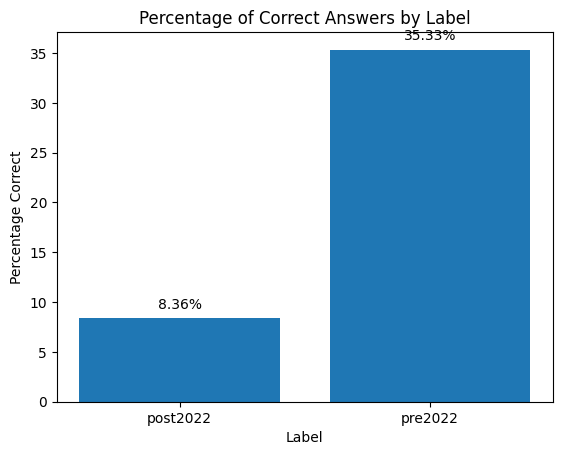

In [ ]:
# prompt: Using dataframe results_df: make a graph showcasing the difrence between post2022 and pre2022 in terms of corectness show as percentage out of 1 write percentage on top of bars too

import matplotlib.pyplot as plt

# Group the data by label and calculate the percentage of correct answers
grouped = results_df.groupby('label')['correct'].mean() * 100

# Create a bar plot
plt.bar(grouped.index, grouped.values)

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Percentage Correct')
plt.title('Percentage of Correct Answers by Label')

# Add percentage values on top of bars
for i, v in enumerate(grouped.values):
  plt.text(i, v + 1, f"{v:.2f}%", ha='center')

# Display the plot
plt.show()
